# Advanced linefollowing ideas
Note that all the ideas on this page remain untested and unsupported by the instructors. It is up to you to use your judgement about which ones (if any) you think will be helpful, and up to you to figure out how to implement them.

All of the ideas on this page assume you have implemented and are very familiar with the [basic line follower](line_following.html). That must be completed before any of the improvements suggested here are attempted.

## Convert P controller errors to meters
This is probably the easiest idea to implement.

In the basic line follower written in this class we perform linear regression on the line and calculate an extension to the line to place a target point in front of the drone. We then feed that point into a P controller designed to make the drone fly to that (continually-shifting) point.

However, all of the error calculations are done in pixel space, while the output velocities are in meters per second. Since the downward camera's field of view increases as the drone's altitude increases, this means that for the drone to have the same error in pixel space (and cause the same P controller response) at a low altitude and a high one requires a much bigger error in meters at the high altitude. This means that the P controller will be much more aggressive at low altitudes than at high ones.

This could be prevented by using the drone's altitude to convert all the P gains to meters (or any other altitude-invariant unit). This was tested briefly by the TAs with encouraging results: it dramatically reduced oscillation when going under the obstacle, which enabled more aggressive gains at normal altitudes.

## Increase speed if the track is straight
The big obstacle to going faster is that either the drone oscillates over the line if its gains are too high, or drifts off the line on curves if its `EXTEND` is too high. However, on straight sections, neither of these pose problems. So, one idea to go faster is to automatically increase either the gains or `EXTEND` if the drone is on a straight line.

This idea was tried by the 2018 Phantom team with considerable success.

## Add a D gain
As the P gain of the line follower is increased, the line follower becomes more and more aggressive until it begins oscillating. The solution to this oscillation is adding in a D term, which acts on the derivative of the error. This will act like a viscous drag force, damping the line follower's oscillations (if the error is getting smaller rapidly, the D term will reduce the speed command, preventing the drone from overshooting and oscillating).

However, this makes the already-difficult tuning problem much worse, as now there is an extra gain to work with. There are many strategies and rules to do this, but none are straightforward.

The D gain also acts as a noise amplifier. For example, if the error has +/- 1 cm of random noise in it each loop, and the control loops runs 100 times per second, that translates to +/- 1m/s of random noise in the derivative term. This can be mitigated with filtering, but tuning the filter adds another term to the tuning problem.

## Linear regression problems
Ideally, when we set the target point we pass to our P controller, we would like to go to the furthest point possible on the line itself. Our current method of doing so treats the line as a mathematical line, finds the centerpoint, and then extends from the centerpoint in the directon of the line a set number of pixels. This works well enough for straight lines, but on curved lines, this encounters problems:

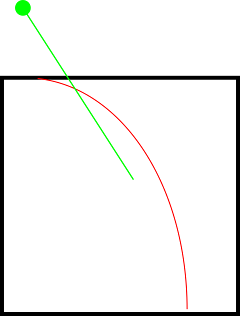

As seen in the image, the green dot which is the target point is outside of the red curved line (which represents the LED strip visible in the downward camera frame). Clearly, the drone is not being told to go to where the line is going, which could cause it to fly off the line. Additionally, if the drone's target angle is that of the green line, the drone will not be pointing in the direction of the red line eithe, which could cause it to miss seeing some obstacles.

### Ignoring the lower half of the line
Another solution would be to ignore the lower half of the line for linear regression purposes. Doing linear regression on only the top part of the line would give a better estimate both of where the line was pointing and its angle.

In 2019, this was given a brief try by the TAs and abandonded because the naive impelmentation (just throw away the botton half of the image) causes the drone to lose the line on turns, as it ignores the line if it is only visible in the lower half of the image.

### Polynomial regression
Using low-order polynomial regression instead of linear regression has the potential to solve both of those problems. A parabola is not a perfect fit to the above curve, but it is much closer. Extending the parabola would result in a target point much closer to where the line is actually going. Also, finding the angle of the parabola near its end would be much closer to the line's angle than the angle derived from linear regression.

However, this technique is much more vulnerable to outliers. It is also much harder to implement than the simple linear regression solution. There is no known nice function to fit a polynomial to an image. `np.polyfit` can fit the polynomial, but it needs a list of points, not an image (which could be generated by `np.argwhere`). Additionally, there is no easy way to implement the polynomial analog of extend, and how to find the angle the drone should turn to needs careful thought.